20171103
Time evolution of matrix product mixed state

In [19]:
import numpy as np
import time
import scipy
from scipy import linalg
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import io

In [158]:
d=2 # Dimension. For spin 1/2 the dimention = 2
J=1. # XX interaction coefficient
gz=0.2 # Z field strength
gx=0. # X field strength
delta =0.005 # Time step
beta=0.001 # inverse temperature
chi=100 # Maximum number of singular values
thr=1e-10; # discarding singular values smaller than thr*largest singular value
t=15
T=int(t/delta)
#T=3;

sx=np.array([[0.,1.],[1.,0.]])
sz=np.array([[1.,0.],[0.,-1.]])
h_int=J*np.kron(sx,sx)
h_single=gz*sz+gx*sx
U_int=linalg.expm(1j*h_int*delta).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')
U_z=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')

Mz=np.kron(sz,np.eye(d))+np.kron(np.eye(d),sz)
Mz=Mz.reshape(d,d,d,d)
Mx=np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx)
Mx=Mx.reshape(d,d,d,d)

#rho0i=np.transpose(np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]]),(2,3,0,1)) # rho0i(si,si',ai,bi)
rho0i=linalg.expm(-beta/2*sx).reshape(d,d,1,1)/np.sqrt(np.exp(beta)+np.exp(-beta)) # rho0i(si,si',ai,bi)
rho0=[rho0i,rho0i]

band0i=np.ones(1)
band0=[band0i,band0i]

def exp1(rho,band,U):
    #1e-6 should be good enough
    E=[]
    for A in range(0,2):
        B=1-A
        theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
        theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(a0,s0,s0',b0)
        theta=np.tensordot(theta,np.conj(theta),axes=([0,2,3],[0,2,3])) # theta(s0,s0*)
        E.append(np.tensordot(theta,U,axes=([0,1],[0,1])))
    return np.mean(E)

def evo1(rho,U):
    for A in range(0,2):
        theta=np.tensordot(U,rho[A],axes=([1,0])) # theta(s,s',a,b,)
        rho[A]=theta

def evo2(rho,band,U,chi):
    for A in range(0,2):
        B=1-A
        #print(A,B)
        dB=(rho[A].shape[2])
        theta=np.tensordot(np.diag(band[B]),rho[A],axes=(0,2)) # theta(a0,s0,s0',b0)
        theta=np.transpose(theta,(1,2,0,3)) # theta(s0,s0',a0,b0)
        theta=np.tensordot(theta,np.diag(band[A]),axes=(3,0)) # theta(s0,s0',a0,b0)
        theta=np.tensordot(theta,rho[B],axes=(3,2)) # theta(s0,s0',a0,s1,s1',b1)
        theta=np.tensordot(theta,np.diag(band[B]),axes=(5,0))# theta(s0,s0',a0,s1,s1',b1)

        # Apply U
        theta=np.tensordot(theta,U,axes=([0,3],[2,3])) # theta(s0',a0,s1',b1,s0,s1)
        theta=np.transpose(theta,(4,0,1,5,2,3)) # theta(s0,s0',a0,s1,s1',b1)
        sh=theta.shape
        theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5]) # theta(s0*s0'*a0,s1*s1'*b1)
        [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
        ent=S.shape[0];
        #print(S)
        for i in range(1,S.shape[0]):
            if S[i]<thr*S[0]:
                ent=i
                break
        if ent<chi:
            D=S[0:ent]
        else:
            ent=chi
            D=S[0:ent]
        sq=np.sqrt(sum(D**2))
        band[A]=D/sq
        L=L[:,0:ent]
        R=R[0:ent,:]
        
        L=L.reshape(d,d,dB,ent) # L(s0,s0',a0,b0)
        L=np.tensordot(L,np.diag(band[B]**-1),axes=(2,0)) # L(s0,s0',b0,a0)
        rho[A]=np.transpose(L,(0,1,3,2))
        R=R.reshape(ent,d,d,dB) # R(a1,s1,s1',b1)
        R=np.tensordot(R,np.diag(band[B]**-1),axes=(3,0)) # R(a1,s1,s1',b1)
        R=np.transpose(R,(1,2,0,3)) # R(s1,s1',a1,b1)
#         test=np.tensordot(L,np.diag(lda[A]),axes=([3,0])) # test(s0,s0',a0,b0)
#         test=np.tensordot(test,R,axes=([3,2])) # test(s0,s0',a0,s1,s1',b1)
        rho[B]=R
#         print('A=',rho[A])
#         print('B=',rho[B])
#         print('bandA=',band[A])
#         print('bandB=',band[B])
def evo(rho,band,U_int,U_single,Nsteps,chi):
    for p in range(0,Nsteps):
        evo2(rho,band,U_int,chi)
        evo1(rho,U_single)

In [ ]:
start=time.time()
T=15 # evolution time to be simulated
Nsteps=2 # number of evolution steps between two measurements
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

rho=list(rho0)
band=list(band0)
MzExp[0]=np.real(exp1(rho,band,sz))
MxExp[0]=np.real(exp1(rho,band,sx))

for p in range(1,Npts):
    evo(rho,band,U_int,U_z,Nsteps,chi)
    MzExp[p]=np.real(exp1(rho,band,sz))
    MxExp[p]=np.real(exp1(rho,band,sx))
    print(tlist[p])
end=time.time()
print(end-start)

In [159]:
start=time.time()
T=1
Npts=round(T/delta) # number of points to evalue the observables
q_max=3
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho=list(rho0)
band=list(band0)
V0=sz # encoding axis

evo(rho,band,U_int,U_z,Npts,chi)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*V0)
    rhot=list(rho)
    bandt=list(band)
    evo1(rhot,U_phi)
    evo(rhot,bandt,np.conj(U_int),np.conj(U_z),Npts,chi)
    s_list=np.append(s_list,np.real(exp1(rhot,bandt,sx)))
    print(phi)
q_list=np.fft.rfft(s_list)#/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))
end=time.time()
print(end-start)

0.0
1.0471975512
2.09439510239
3.14159265359
4.18879020479
5.23598775598
18.408390045166016


In [160]:
exp1(rho0,band0,sx)-s_list[0]

-3.4507545657730399e-09

In [161]:
s_list

array([-0.001     , -0.00047822,  0.00048111,  0.001     ,  0.00047822,
       -0.00048111])

In [162]:
otoc/0.0029999990000021425

1.2304694889699674

In [50]:
otoc

0.0029999990000021425

In [121]:
U_z*np.conj(U_z)

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j]])

In [35]:
tlist=np.arange(0,T*delta,delta)
plt.plot(np.arange(0,15.05,0.05),MxExp1/MxExp1[0])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


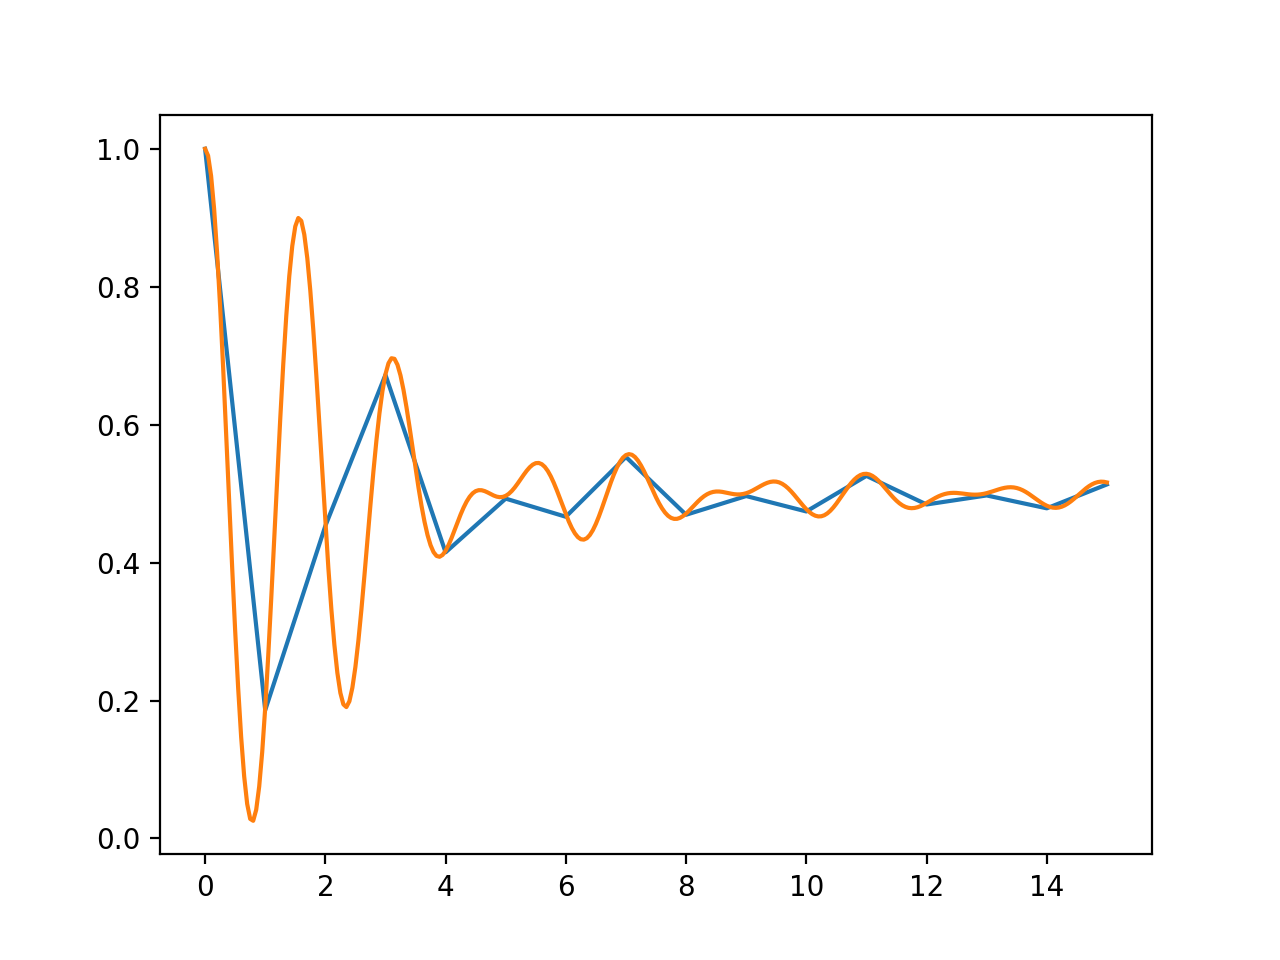

In [34]:
plt.plot(tlist,MzExp/MzExp[0])
plt.show()

In [7]:
dictpp=io.loadmat('M_z')

MxExp1=dictpp['M_z']

MxExp1=np.squeeze(MxExp1)

MxExp1.shape

(301,)

In [29]:
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

In [30]:
tlist

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.])